# Random walks on the spanning cluster

In this notebook we'll explore diffusion on the spanning cluster.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.ndimage

from generate_spanning_cluster import get_spanning_cluster
from percwalk import percwalk

In [2]:
sns.set(color_codes=True)

In [3]:
# Critical percolation probability
p_c = 0.59275

## Distance moved on the percolating cluster

We'll start by exploring diffusion on the percolating cluster for $p > p_c$. We'll measure the second moment of the average distance, $\langle R^2 \rangle$, as a function of the number of steps performed.

In [4]:
perc_labels, labels, num_labels, z = get_spanning_cluster(100, p_c)

Percolating cluster found


In [5]:
label_list = np.arange(num_labels + 1)
area = scipy.ndimage.measurements.sum(z, labels, index=label_list)
area_image = area[labels]
spanning_cluster = labels == perc_labels[0]

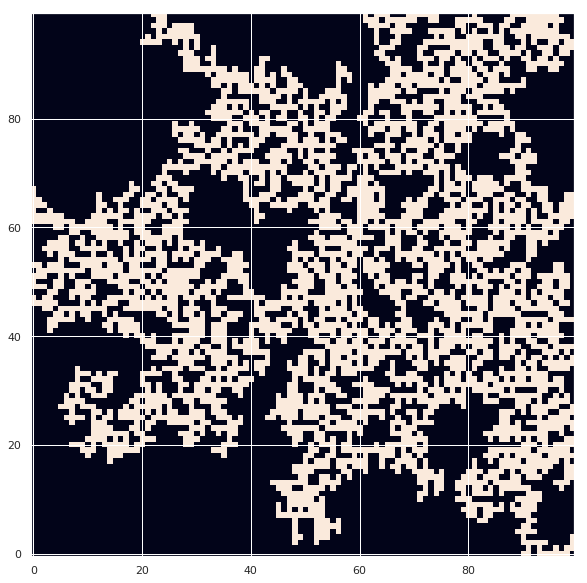

In [6]:
plt.figure(figsize=(14, 10))

plt.imshow(spanning_cluster, origin="lower")
plt.show()

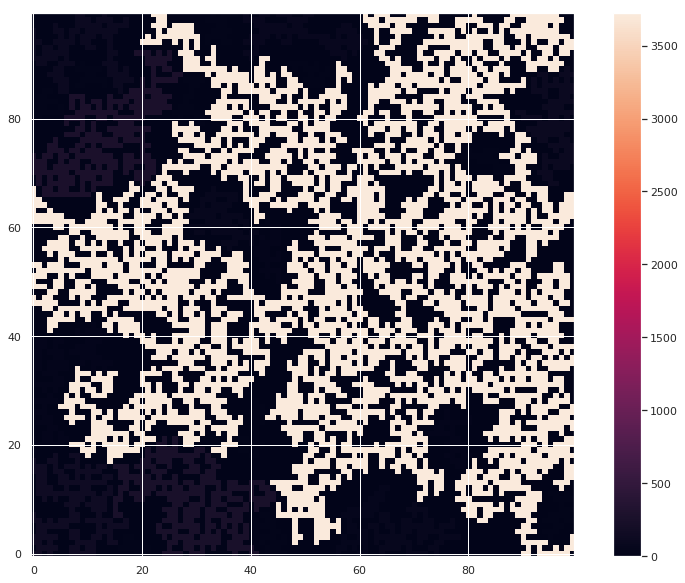

In [7]:
plt.figure(figsize=(14, 10))

plt.imshow(area_image, interpolation="nearest", origin="lower")
plt.colorbar()
plt.show()

In [8]:
num_walks = int(1e5)
num_steps = 0

In [9]:
while num_steps <= 1:
    walker_map, displacements, num_steps = percwalk(spanning_cluster, num_walks)

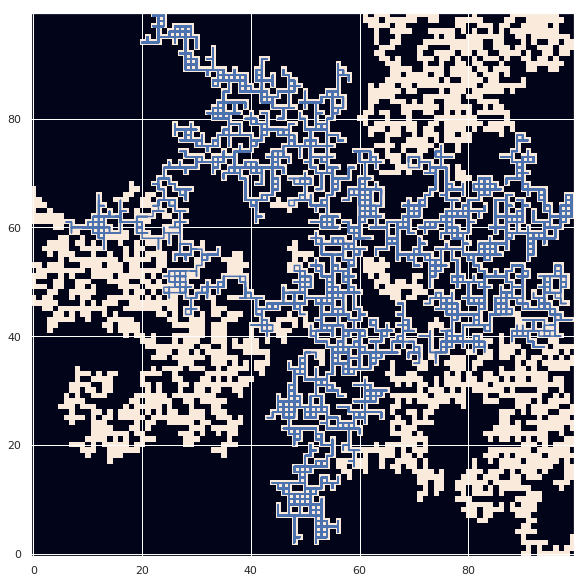

In [10]:
plt.figure(figsize=(14, 10))

plt.imshow(spanning_cluster, origin="lower")
# walker_map is oriented as row-column (ix, iy)
plt.plot(walker_map[1], walker_map[0])
plt.show()

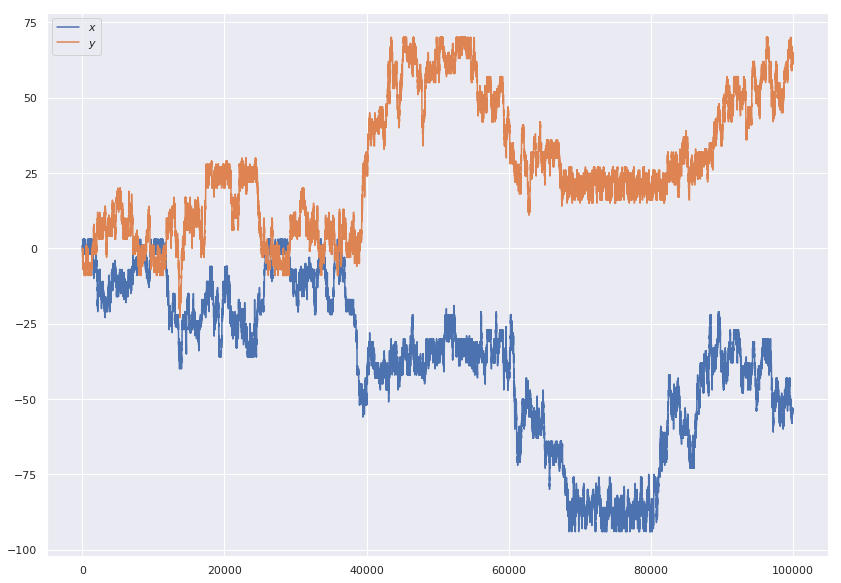

In [11]:
plt.figure(figsize=(14, 10))

plt.plot(displacements[0], label=r"$x$")
plt.plot(displacements[1], label=r"$y$")
plt.legend(loc="best")
plt.show()

In [13]:
squared_distance = np.sum(displacements ** 2, axis=0)